In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install keras_preprocessing


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [5]:
#Data Science Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [7]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-07-04 20:40:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-04 20:40:43 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [8]:
dataset = "/content/drive/MyDrive/fire_dataset-2"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/drive/MyDrive/fire_dataset-2'.
There are 0 directories and 755 images in '/content/drive/MyDrive/fire_dataset-2/fire_images'.
There are 0 directories and 244 images in '/content/drive/MyDrive/fire_dataset-2/non_fire_images'.


In [9]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [11]:
len(list(image_dir.glob(r'**/*.png')))


999

In [12]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
1,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
2,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
3,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
4,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
...,...,...
994,/content/drive/MyDrive/fire_dataset-2/non_fire...,non_fire_images
995,/content/drive/MyDrive/fire_dataset-2/non_fire...,non_fire_images
996,/content/drive/MyDrive/fire_dataset-2/non_fire...,non_fire_images
997,/content/drive/MyDrive/fire_dataset-2/non_fire...,non_fire_images


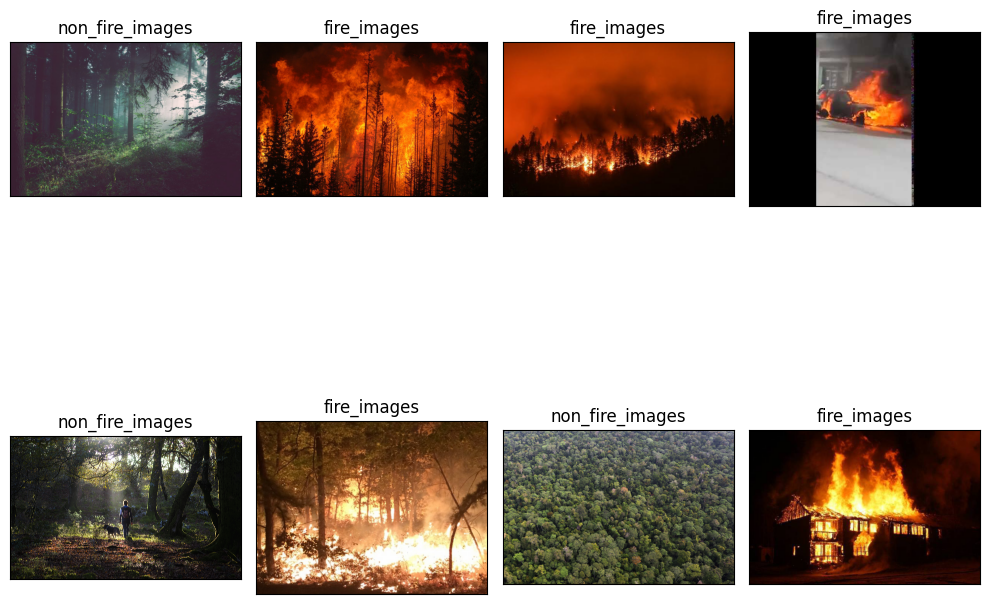

In [15]:
import matplotlib.image as mpimg
# Display 8 picture with their labels
random_index = np.random.randint(0, len(image_df), 8)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

**Preparation of Data**


In [16]:
# Separate the Data as %20 test and %80 train
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [17]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [18]:
# Split the data train,test and validation
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [21]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [23]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [24]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [27]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20230704-210029
Epoch 1/20
20/20 [==============================] - 76s 4s/step - loss: 0.3604 - accuracy: 0.8266 - val_loss: 0.1743 - val_accuracy: 0.9308
Epoch 2/20
20/20 [==============================] - 60s 3s/step - loss: 0.1629 - accuracy: 0.9500 - val_loss: 0.1046 - val_accuracy: 0.9560
Epoch 3/20
20/20 [==============================] - 61s 3s/step - loss: 0.1068 - accuracy: 0.9625 - val_loss: 0.0778 - val_accuracy: 0.9874
Epoch 4/20
20/20 [==============================] - 60s 3s/step - loss: 0.0835 - accuracy: 0.9797 - val_loss: 0.0663 - val_accuracy: 0.9874
Epoch 5/20
20/20 [==============================] - 72s 4s/step - loss: 0.0633 - accuracy: 0.9828 - val_loss: 0.0598 - val_accuracy: 0.9937
Epoch 6/20
20/20 [==============================] - 64s 3s/step - loss: 0.0563 - accuracy: 0.9859 - val_loss: 0.0560 - val_accuracy: 0.9937
Epoch 7/20
20/20 [==============================] - 70s 3s/step - loss: 0.046

In [28]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.03324
Test Accuracy: 98.50%


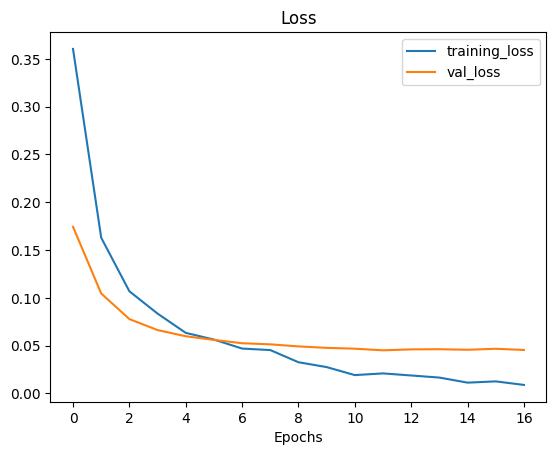

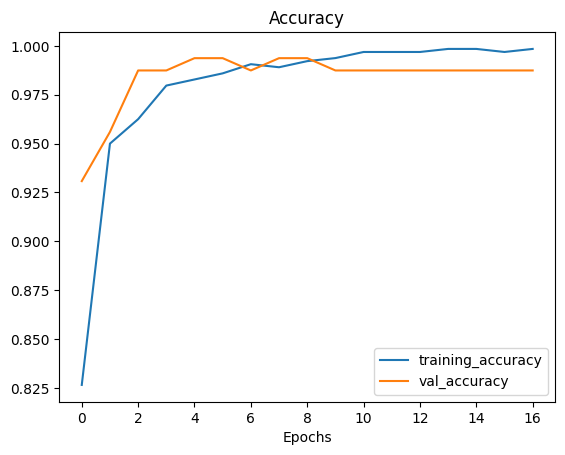

In [29]:
plot_loss_curves(history)

In [30]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 15s 2s/step
The first 5 predictions: ['fire_images', 'non_fire_images', 'fire_images', 'fire_images', 'fire_images']


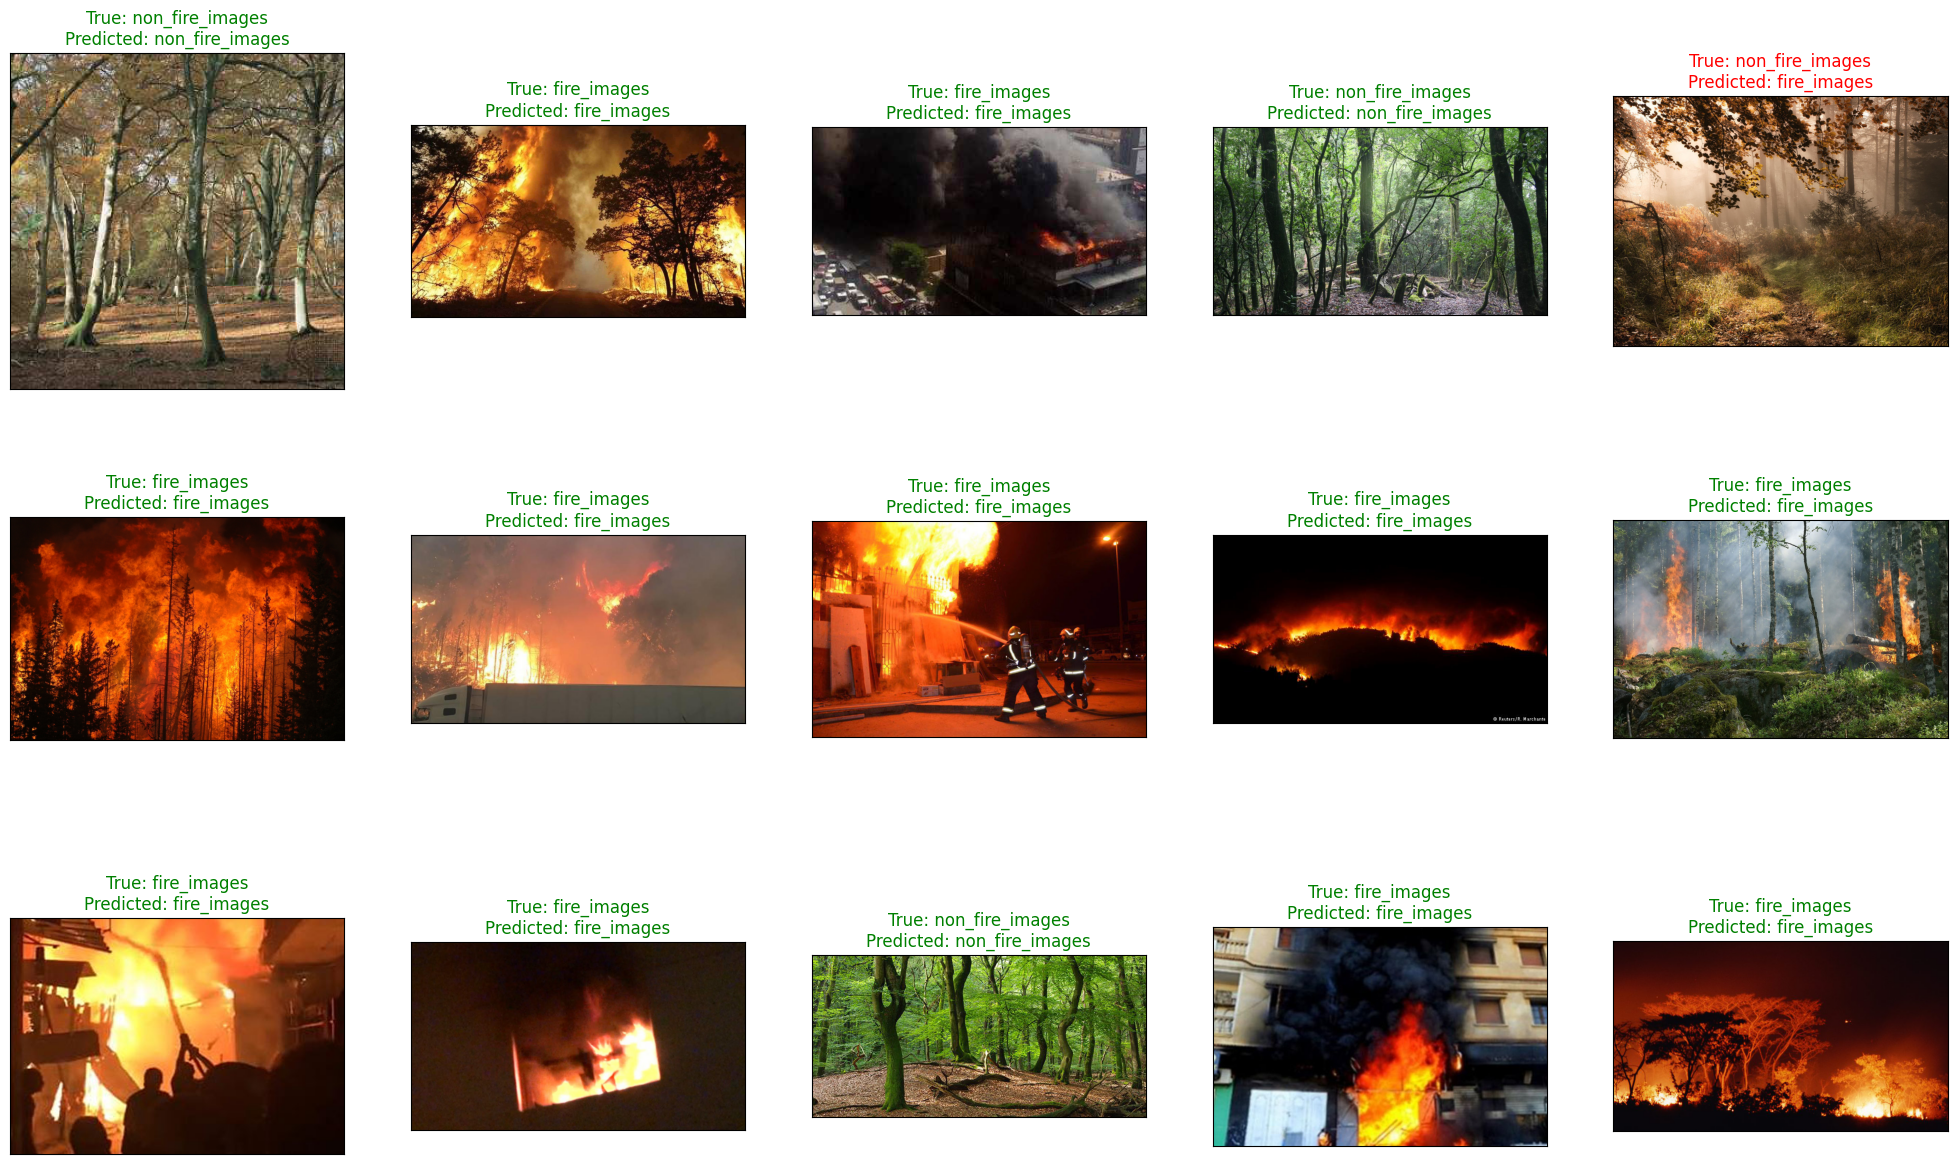

<Figure size 640x480 with 0 Axes>

In [31]:
  # Display 15 random pictures with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [32]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.98      1.00      0.99       148
non_fire_images       1.00      0.94      0.97        52

       accuracy                           0.98       200
      macro avg       0.99      0.97      0.98       200
   weighted avg       0.99      0.98      0.98       200



In [33]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
fire_images,0.980132,1.000000,0.989967,148.000
non_fire_images,1.000000,0.942308,0.970297,52.000
accuracy,0.985000,0.985000,0.985000,0.985
macro avg,0.990066,0.971154,0.980132,200.000
weighted avg,0.985298,0.985000,0.984852,200.000


In [34]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):

  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


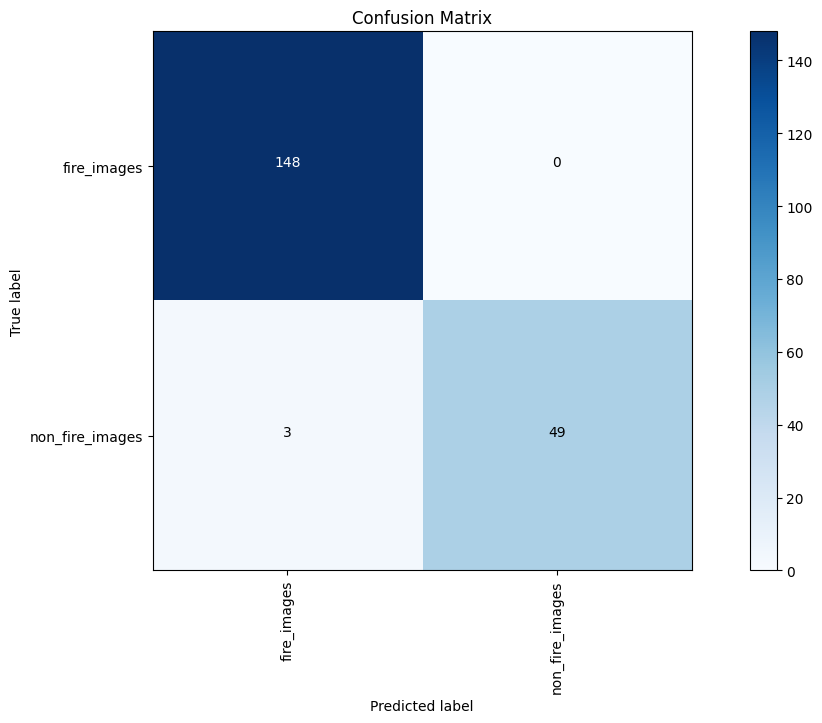

In [35]:
make_confusion_matrix(y_test, pred, list(labels.values()))